# EDA

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
sys.path.append(os.path.abspath(".."))

from src.EDA import plot_feat_histogram, skew_kurtosis

Starting with the essentials: pandas for data manipulation, matplotlib and seaborn for visualization. We'll also define a custom histogram function early on since we'll need it multiple times to explore feature distributions and check for skewness.

## Load the dataset

In [3]:
df = pd.read_csv('../data/unprocessed/compas-scores-two-years.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

Loading the raw COMPAS dataset from ProPublica. This contains information about defendants from Broward County, Florida, including their criminal history, demographics, and whether they recidivated. Let's check the structure and see what we're working with.

In [4]:
df = df[[
    "juv_fel_count", "juv_misd_count",
    "c_charge_degree", "race", "age_cat", "sex",
    "priors_count", "days_b_screening_arrest",
    "is_recid", "c_jail_in", "c_jail_out"
]]

# Apply filters one by one
df = df[df["days_b_screening_arrest"] <= 30]
df = df[df["days_b_screening_arrest"] >= -30]
df = df[df["is_recid"] != -1]
df = df[df["c_charge_degree"] != "O"]

# Added a new feature for jail days
df["c_jail_in"] = pd.to_datetime(df["c_jail_in"])
df["c_jail_out"] = pd.to_datetime(df["c_jail_out"])
df["jail_days"] = (df["c_jail_out"] - df["c_jail_in"]).dt.days
df.drop(columns=["c_jail_in", "c_jail_out"], inplace=True)

print(f'df has shape: {df.shape} after filtering')

df has shape: (6172, 10) after filtering


First comes the critical data cleaning step. Following ProPublica's methodology, we apply strict filters to ensure data quality: only cases where screening happened within 30 days of arrest, removing invalid recidivism flags (-1), and excluding minor traffic offenses that wouldn't result in jail time. We also select only the features relevant for our prediction task. These filters are not arbitrary, they're based on the original ProPublica analysis to ensure we're working with reliable, comparable data.

Now, let's begin to inspect some of the remaining data:

## Missing values

In [5]:
missing_vals = {}

for cols in df.columns:
    missing_count = df[cols].isnull().sum()
    if missing_count > 0:
        missing_vals[cols] = missing_count

missing_vals

{}

Checking for missing values is essential before modeling. Missing data can introduce bias or cause errors during training. If we find any nulls, we'll need to decide whether to impute, drop, or handle them in some other way. An empty dictionary here is good news, it means our filtered data is complete.

## Duplicates

Duplicate rows can artificially inflate patterns and lead to overfitting. Our model might memorize repeated instances rather than learning generalizable patterns. Even a few duplicates can skew results in ways that aren't immediately obvious, so it's important to identify them early.

In [6]:
duplicates = df.duplicated().sum()
print(f'The number of duplicate rows in the dataset is: {duplicates}')

The number of duplicate rows in the dataset is: 2236


Duplicates in the COMPAS dataset should not be removed because they are not true duplicates, they represent multiple legitimate assessments for the same individual, often tied to different charges, cases, or parallel risk evaluations. Dropping them would remove real historical records, distort class balance, and reduce the amount of training data, ultimately harming the model’s ability to learn meaningful patterns. Retaining these rows preserves the dataset’s real-world structure and ensures the model reflects the full assessment history of each person.

## Skewness and Kurtosis of Numerical Features

Understanding the distribution shape of numerical features helps us make informed decisions about transformations. Highly skewed features (especially with high kurtosis) can cause problems for models that assume normality or are sensitive to outliers. Features with extreme skewness might benefit from log transforms, binning, or other preprocessing techniques to improve model performance.

In [7]:
for feat in df.select_dtypes(include=['int64', 'float64']).columns:
    print("---")
    skew_kurtosis(df, feat)

---
Feature: juv_fel_count
 skewness: 19.65
 kurtosis: 644.80
 The feature is positively skewed with high kurtosis.
---
Feature: juv_misd_count
 skewness: 10.93
 kurtosis: 186.13
 The feature is positively skewed with high kurtosis.
---
Feature: priors_count
 skewness: 2.41
 kurtosis: 7.06
 The feature is positively skewed with high kurtosis.
---
Feature: days_b_screening_arrest
 skewness: -2.14
 kurtosis: 16.49
 The feature does NOT exhibit strong positive skewness and high kurtosis.
---
Feature: is_recid
 skewness: 0.06
 kurtosis: -2.00
 The feature does NOT exhibit strong positive skewness and high kurtosis.
---
Feature: jail_days
 skewness: 6.55
 kurtosis: 60.32
 The feature is positively skewed with high kurtosis.


To those features that are positively skewed with high kurtosis, we will later use StandardScaler to standardize the values so regression and distance based models are not impacted by the different scales of values

In [8]:
df['days_b_screening_arrest'] = df['days_b_screening_arrest'].clip(lower=0)

A small but important adjustment: clipping negative values in `days_b_screening_arrest` to zero. Negative values mean the screening happened before the arrest, which doesn't make logical sense for our purposes, so we normalize these edge cases.

In [9]:
df.head()

,juv_fel_count,juv_misd_count,c_charge_degree,race,age_cat,sex,priors_count,days_b_screening_arrest,is_recid,jail_days
0,0,0,F,Other,Greater than 45,Male,0,0.0,0,0
1,0,0,F,African-American,25 - 45,Male,0,0.0,1,10
2,0,0,F,African-American,Less than 25,Male,4,0.0,1,1
5,0,0,M,Other,25 - 45,Male,0,0.0,0,1
6,0,0,F,Caucasian,25 - 45,Male,14,0.0,1,6


Quick sanity check. Let's preview the first few rows to make sure our filtering worked as expected and the data looks reasonable.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6172 entries, 0 to 7213
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   juv_fel_count            6172 non-null   int64  
 1   juv_misd_count           6172 non-null   int64  
 2   c_charge_degree          6172 non-null   object 
 3   race                     6172 non-null   object 
 4   age_cat                  6172 non-null   object 
 5   sex                      6172 non-null   object 
 6   priors_count             6172 non-null   int64  
 7   days_b_screening_arrest  6172 non-null   float64
 8   is_recid                 6172 non-null   int64  
 9   jail_days                6172 non-null   int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 530.4+ KB


## Convert data types

All datatypes seems correct and appropiate. Hence, there's no need for conversion

## Data Analysis (EDA)

In [11]:
df["age_cat"].value_counts().sort_index()

age_cat
25 - 45            3532
Greater than 45    1293
Less than 25       1347
Name: count, dtype: int64

Time to explore the data! Let's start by understanding the demographic and criminal history distributions. Age categories first are we dealing mostly with young offenders or an older population? This matters because age is often correlated with recidivism risk.

In [12]:
df["race"].value_counts().sort_index

<bound method Series.sort_index of race
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: count, dtype: int64>

In [13]:
race_counts = df["race"].value_counts()
for race in race_counts.index:
	percentage = (race_counts[race] / df.shape[0] * 100)
	print(f"{race} defendants: {percentage:.2f}%")

African-American defendants: 51.44%
Caucasian defendants: 34.07%
Hispanic defendants: 8.25%
Other defendants: 5.56%
Asian defendants: 0.50%
Native American defendants: 0.18%


Understanding racial composition is crucial for this dataset. The COMPAS algorithm has been controversial partly due to concerns about racial bias, so we need to know the demographic breakdown. Calculating percentages gives us a clearer picture than raw counts.

In [14]:
df["sex"].value_counts().sort_index()

sex
Female    1175
Male      4997
Name: count, dtype: int64

Male defendants: 80.96%
Female defendants: 19.04%


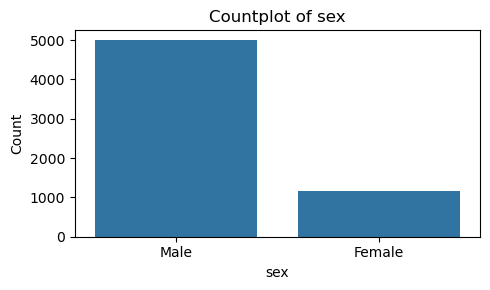

In [15]:
gender_counts = df["sex"].value_counts()
for gender in gender_counts.index:
	percentage = (gender_counts[gender] / df.shape[0] * 100)
	print(f"{gender} defendants: {percentage:.2f}%")

plt.figure(figsize=(5, 3))
sns.countplot(x="sex", data=df)
plt.title("Countplot of sex")
plt.xlabel("sex")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Gender distribution is another demographic factor to examine. Criminal justice data typically shows strong gender imbalances, with males being overrepresented. Let's visualize this to confirm the pattern in our dataset.

In [16]:
pd.crosstab(df["sex"], df["race"])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


A crosstab helps us see the intersection of gender and race—understanding these demographic intersections can reveal important patterns or potential biases in the data.

In [17]:
reoff_lifetime = df[df["is_recid"] == 1]
no_reoff_lifetime = df[df["is_recid"] == 0]

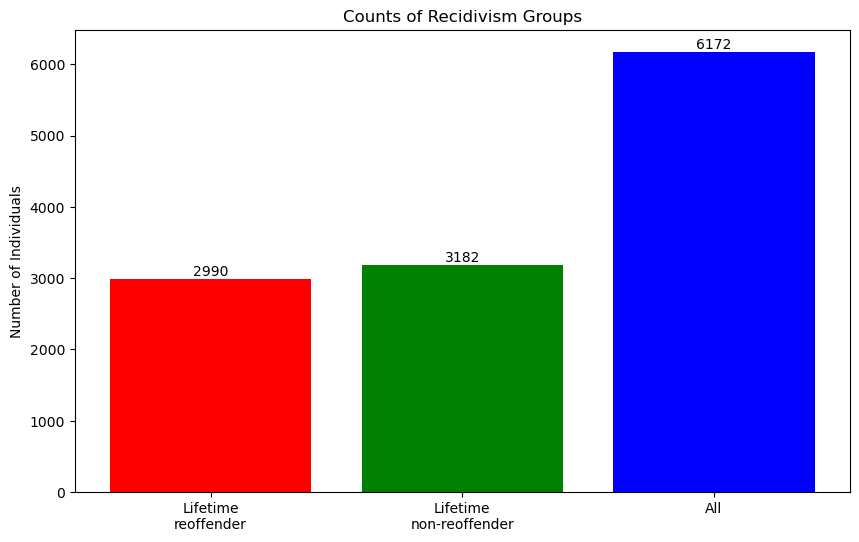

In [18]:
counts = {
    "Lifetime\nreoffender": len(reoff_lifetime),
    "Lifetime\nnon-reoffender": len(no_reoff_lifetime),
    "All": len(df)
}

plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values(), color=["red", "green", "blue", "orange", "purple"])

plt.title("Counts of Recidivism Groups")
plt.ylabel("Number of Individuals")
plt.xticks(rotation=0)

for i, v in enumerate(counts.values()):
    plt.text(i, v + 50, str(v), ha='center', fontsize=10)

plt.show()

Now for the key question: what's our class balance? Splitting the dataset into recidivists and non-recidivists tells us how imbalanced our target variable is. This will heavily influence our modeling approach if one class dominates, we'll need special techniques to avoid a model that just predicts the majority class.

Prior convictions are one of the strongest predictors of recidivism. Let's create a comprehensive view showing how `priors_count` relates to recidivism, and how it's distributed across gender, race, and charge degree. These multi-dimensional views help us understand if certain groups have systematically different criminal histories, which could indicate bias or real underlying patterns we need to account for.

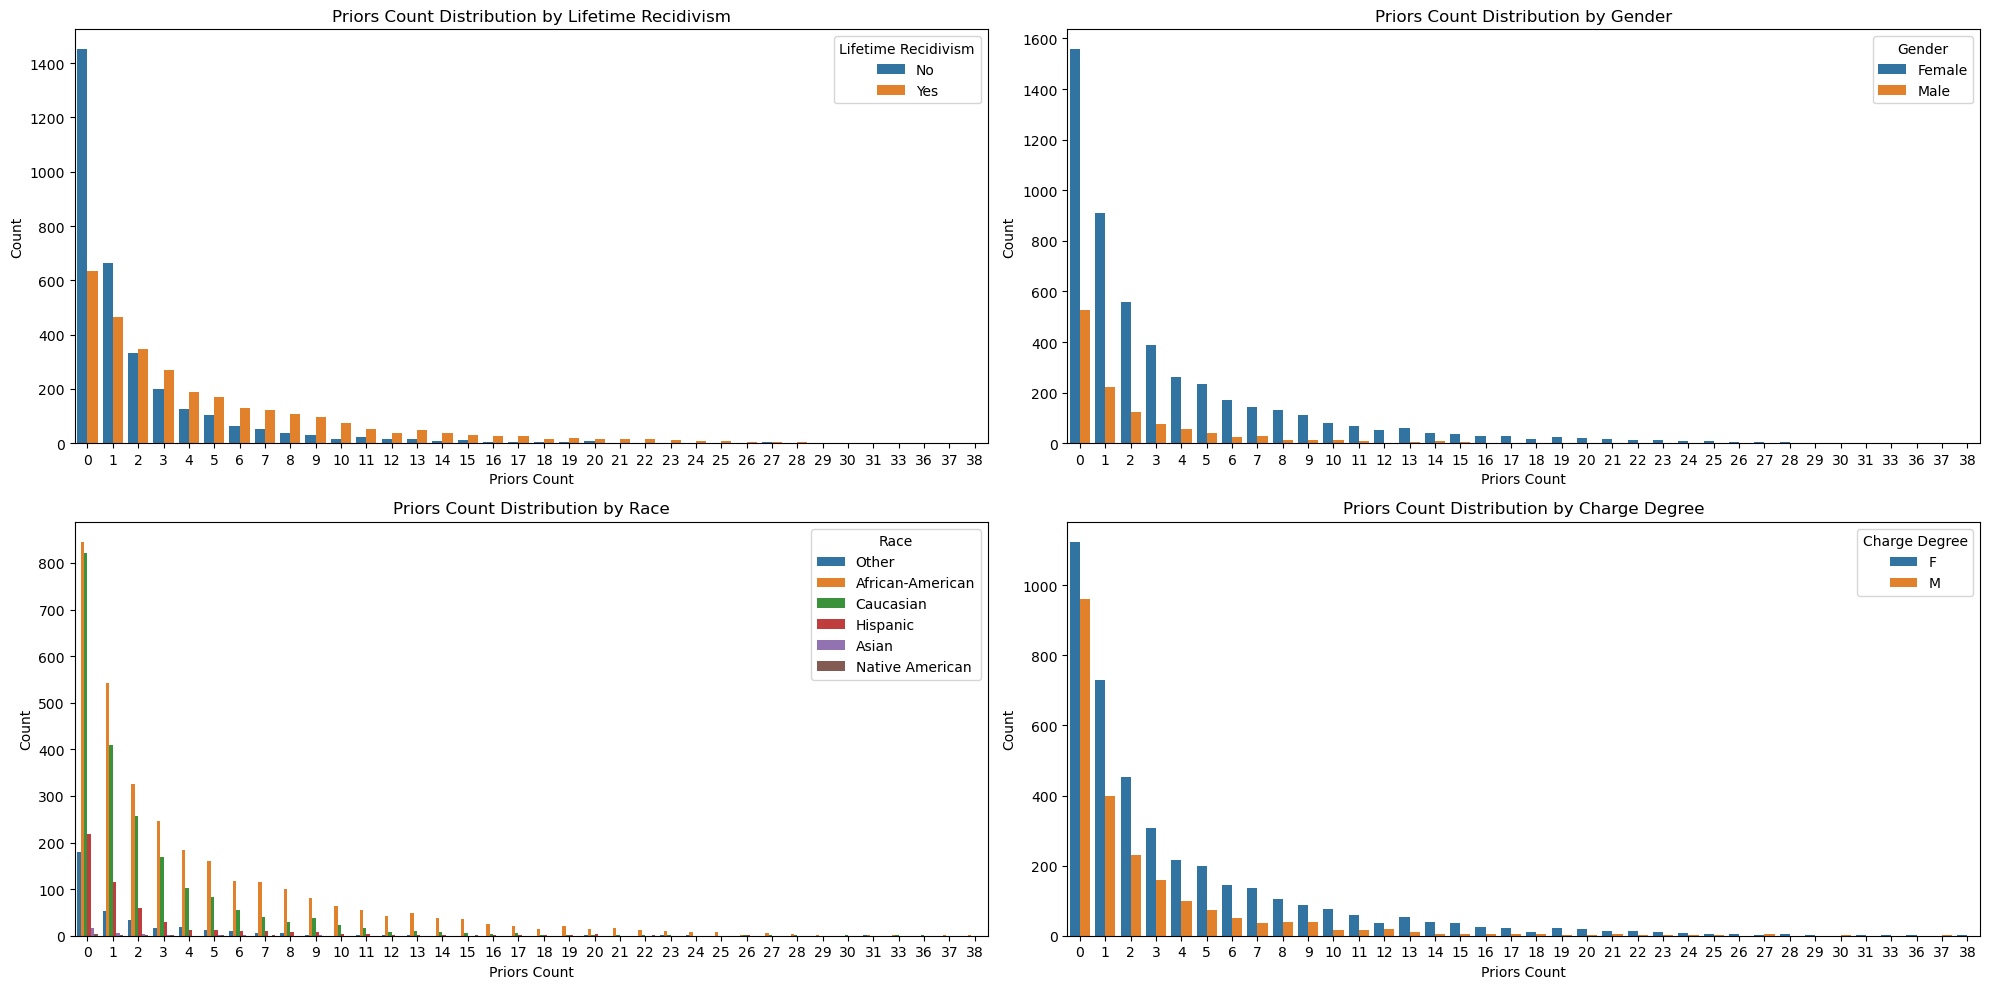

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

sns.countplot(data=df, x="priors_count", hue="is_recid", ax=axes[0])
axes[0].set_title("Priors Count Distribution by Lifetime Recidivism")
axes[0].set_xlabel("Priors Count")
axes[0].set_ylabel("Count")
axes[0].legend(title="Lifetime Recidivism", labels=["No", "Yes"])

sns.countplot(data=df, x="priors_count", hue="sex", ax=axes[1])
axes[1].set_title("Priors Count Distribution by Gender")
axes[1].set_xlabel("Priors Count")
axes[1].set_ylabel("Count")
axes[1].legend(title="Gender", labels=["Female", "Male"])  

sns.countplot(data=df, x="priors_count", hue="race", ax=axes[2])
axes[2].set_title("Priors Count Distribution by Race")
axes[2].set_xlabel("Priors Count")
axes[2].set_ylabel("Count")
axes[2].legend(title="Race")

sns.countplot(data=df, x="priors_count", hue="c_charge_degree", ax=axes[3])
axes[3].set_title("Priors Count Distribution by Charge Degree")
axes[3].set_xlabel("Priors Count")
axes[3].set_ylabel("Count")
axes[3].legend(title="Charge Degree")


plt.tight_layout()
plt.show()

Across all demographic and case-related groups, the distribution of prior offenses is highly right-skewed, with the majority of individuals having 0–2 prior offenses and a long tail extending toward higher prior counts.

Recidivists consistently show higher prior counts than non-recidivists, reinforcing the strong relationship between criminal history and risk of reoffending. Males tend to have more priors than females, and racial groups show distinct patterns, with African-American individuals exhibiting a heavier concentration in higher prior categories. Charge degree (felony vs misdemeanor) also correlates with prior count, as felony cases tend to involve individuals with more extensive histories.

Overall, these distributions confirm that priors_count is a highly informative predictive feature, but also one that reflects structural differences across groups—important to consider when evaluating fairness.

Before we engineer more complex features, let's encode our categorical variables. Using one-hot encoding with `drop_first=True` converts categories like race, sex, and age into binary columns while avoiding multicollinearity (the dummy variable trap). This encoded dataset will serve as our baseline for modeling and help us visualize correlations between all features.

In [20]:
# One-hot encode categorical features
df_encoded = df.copy()

# Convert categorical features to category dtype for proper encoding
categorical_cols = ['c_charge_degree', 'race', 'age_cat', 'sex', 'priors_category', 'jail_time_category']
for col in categorical_cols:
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].astype(str)

# Apply one-hot encoding with drop_first=True to avoid multicollinearity
df_encoded = pd.get_dummies(df_encoded, drop_first=True, dtype=int)

print(f"Encoded dataset shape: {df_encoded.shape}")
print(f"\nColumn names after encoding:")
print(df_encoded.columns.tolist())
print(f"\nFeature count: {len(df_encoded.columns)}")

df_encoded.head()

Encoded dataset shape: (6172, 15)

Column names after encoding:
['juv_fel_count', 'juv_misd_count', 'priors_count', 'days_b_screening_arrest', 'is_recid', 'jail_days', 'c_charge_degree_M', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'sex_Male']

Feature count: 15


,juv_fel_count,juv_misd_count,priors_count,days_b_screening_arrest,is_recid,jail_days,c_charge_degree_M,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,age_cat_Greater than 45,age_cat_Less than 25,sex_Male
0,0,0,0,0.0,0,0,0,0,0,0,0,1,1,0,1
1,0,0,0,0.0,1,10,0,0,0,0,0,0,0,0,1
2,0,0,4,0.0,1,1,0,0,0,0,0,0,0,1,1
5,0,0,0,0.0,0,1,1,0,0,0,0,1,0,0,1
6,0,0,14,0.0,1,6,0,0,1,0,0,0,0,0,1


## Feature Engineering

In [21]:
# Total juvenile offenses
df_encoded['total_juv_offenses'] = df_encoded['juv_fel_count'] + df_encoded['juv_misd_count']

# Has juvenile record (binary indicator)
df_encoded['has_juv_record'] = (df_encoded['total_juv_offenses'] > 0).astype(int)

# Age x Priors interaction (high-risk combination)
# Young offenders with many priors are particularly high-risk
df_encoded['young_with_priors'] = ((df_encoded['age_cat_Less than 25'] == 1) & (df_encoded['priors_count'] > 2)).astype(int)

print("Engineered features created:")
print(f"- total_juv_offenses: {df_encoded['total_juv_offenses'].describe()}")
print(f"- has_juv_record: {df_encoded['has_juv_record'].value_counts()}")
print(f"- young_with_priors: {df_encoded['young_with_priors'].value_counts()}")

df_encoded.head()

Engineered features created:
- total_juv_offenses: count    6172.000000
mean        0.150518
std         0.706840
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        20.000000
Name: total_juv_offenses, dtype: float64
- has_juv_record: has_juv_record
0    5664
1     508
Name: count, dtype: int64
- young_with_priors: young_with_priors
0    5929
1     243
Name: count, dtype: int64


,juv_fel_count,juv_misd_count,priors_count,days_b_screening_arrest,is_recid,jail_days,c_charge_degree_M,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,age_cat_Greater than 45,age_cat_Less than 25,sex_Male,total_juv_offenses,has_juv_record,young_with_priors
0,0,0,0,0.0,0,0,0,0,0,0,0,1,1,0,1,0,0,0
1,0,0,0,0.0,1,10,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,4,0.0,1,1,0,0,0,0,0,0,0,1,1,0,0,1
5,0,0,0,0.0,0,1,1,0,0,0,0,1,0,0,1,0,0,0
6,0,0,14,0.0,1,6,0,0,1,0,0,0,0,0,1,0,0,0


Now for feature engineering! Rather than just using the raw features, we can create more informative ones. Combining juvenile felonies and misdemeanors gives us total juvenile offense count. Creating binary indicators (like `has_juv_record`) simplifies the signal for models. The `young_with_priors` interaction feature captures a high-risk combination—young defendants with extensive criminal histories are particularly likely to reoffend. These engineered features can help our models detect patterns that might be missed with raw data alone.

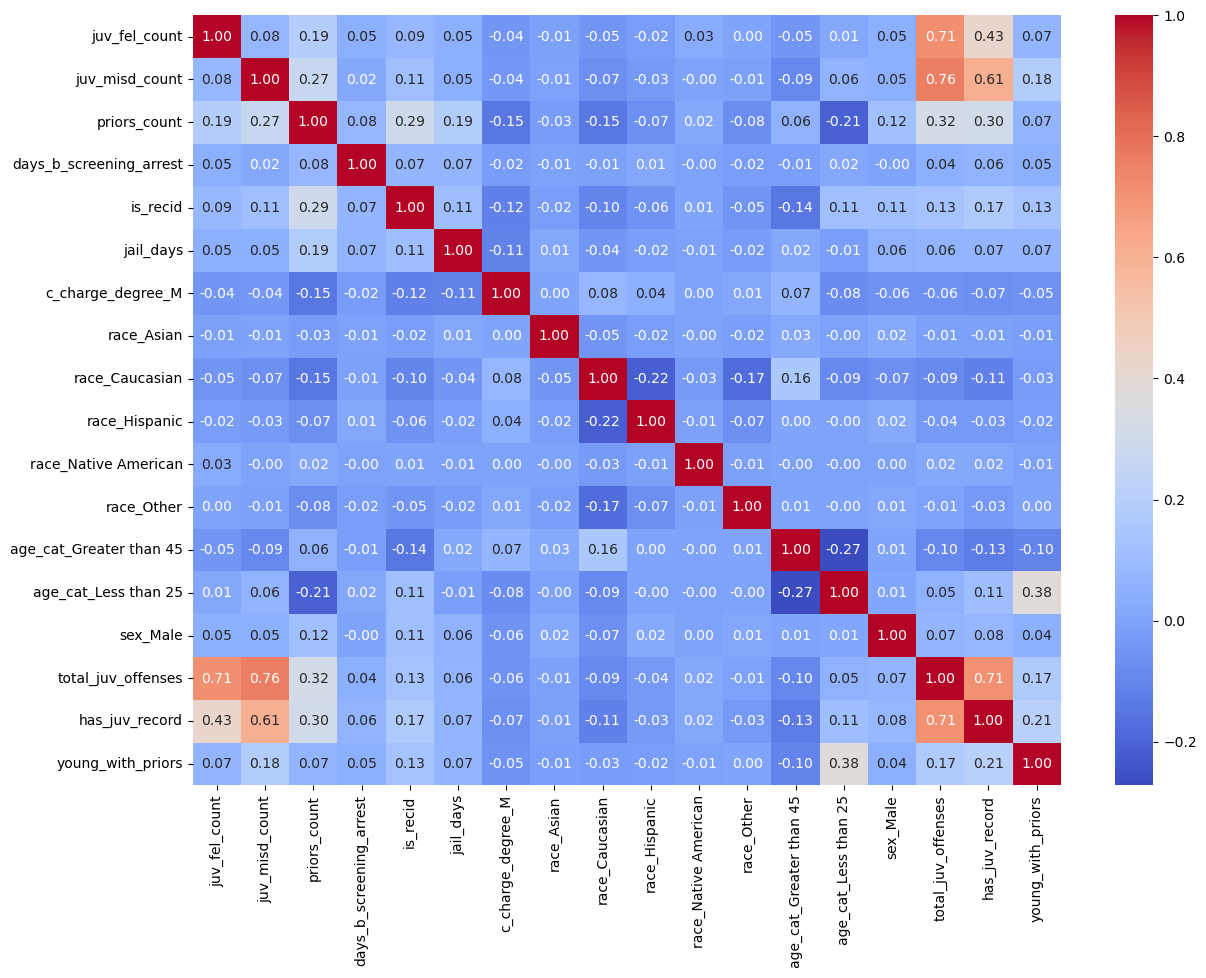

In [22]:
corr = df_encoded.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f")
plt.show()

A correlation heatmap gives us the big picture of feature relationships. Which features are strongly correlated with `is_recid`? Are any features highly correlated with each other (potential multicollinearity issues)? This visual guide helps prioritize which features to focus on and identify redundancies.

The correlation heatmap reveals that most features in the dataset are weakly correlated, with only a few clusters showing moderate relationships. Juvenile offense variables (e.g., `juv_fel_count`, `juv_misd_count`) correlate naturally with `total_juv_offenses`, and `priors_count` correlates moderately with `has_juv_record` and `young_with_priors`. These patterns are expected because these features measure related aspects of an individual’s criminal history. Importantly, none of the predictors show strong correlation with the target variable (`is_recid`), meaning there is no evidence of data leakage. The correlations instead reflect meaningful structure: criminal history variables cluster together, categorical encodings remain isolated, and no future-information or outcome-based features accidentally feed into the model.

## Visualize Engineered Features

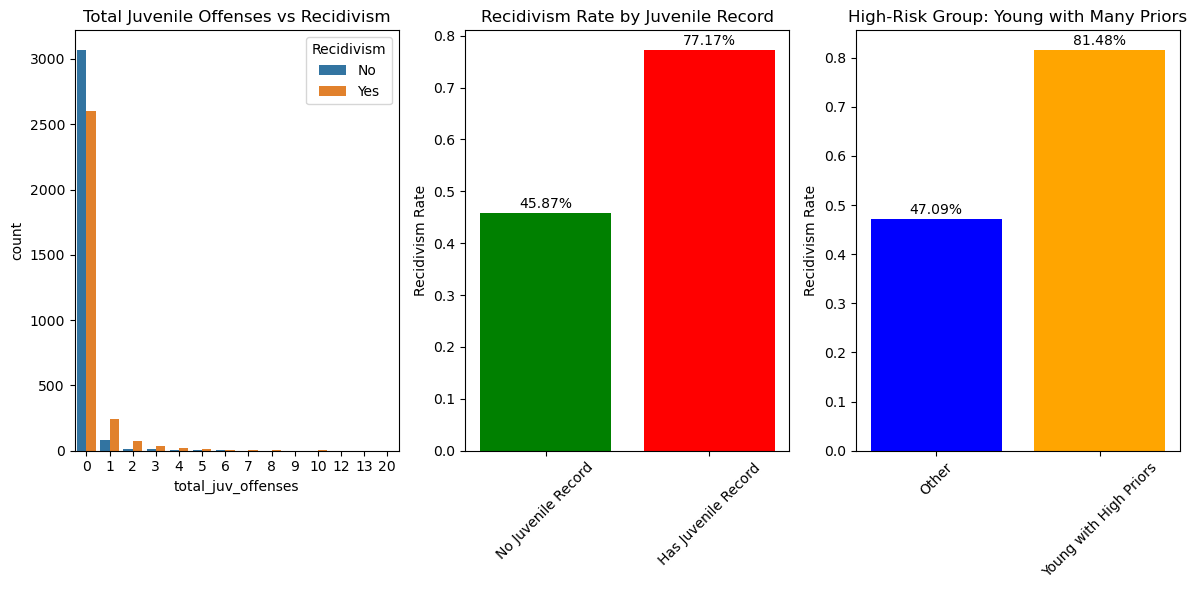

In [23]:
# Visualize engineered features' relationship with recidivism
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes = axes.flatten()

# Total juvenile offenses vs recidivism
sns.countplot(data=df_encoded, x='total_juv_offenses', hue='is_recid', ax=axes[0])
axes[0].set_title('Total Juvenile Offenses vs Recidivism')
axes[0].legend(title='Recidivism', labels=['No', 'Yes'])

# Has juvenile record vs recidivism rate
juv_recid = df_encoded.groupby('has_juv_record')['is_recid'].mean()
axes[1].bar(['No Juvenile Record', 'Has Juvenile Record'], juv_recid.values, color=['green', 'red'])
axes[1].set_title('Recidivism Rate by Juvenile Record')
axes[1].set_ylabel('Recidivism Rate')
for i, v in enumerate(juv_recid.values):
    axes[1].text(i, v + 0.01, f'{v:.2%}', ha='center')
axes[1].tick_params(axis='x', rotation=45)

# Young with priors indicator
young_priors_recid = df_encoded.groupby('young_with_priors')['is_recid'].mean()
axes[2].bar(['Other', 'Young with High Priors'], young_priors_recid.values, color=['blue', 'orange'])
axes[2].set_title('High-Risk Group: Young with Many Priors')
axes[2].set_ylabel('Recidivism Rate')
for i, v in enumerate(young_priors_recid.values):
    axes[2].text(i, v + 0.01, f'{v:.2%}', ha='center')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Let's validate our feature engineering by visualizing how these new features relate to recidivism. Do defendants with juvenile records really have higher recidivism rates? Is the "young with high priors" group truly high-risk? These plots confirm whether our feature engineering intuitions are supported by the data—if they show strong patterns, our engineered features are worth including in the model.

These plots show a strong relationship between juvenile criminal history and the likelihood of adult recidivism. Individuals with more juvenile offenses are disproportionately represented among recidivists, with the distribution showing that even a small number of early offenses significantly increases the chance of reoffending. The second chart highlights this more clearly: adults with a juvenile record recidivate at a rate of about 77%, compared to only 46% for those without one. Finally, the high-risk subgroup plot shows that individuals who were young at the time of assessment and had multiple prior offenses have the highest recidivism rates—over 81%, making them the most at-risk category. Overall, the figures indicate that early criminal involvement specially persistent juvenile offending is one of the strongest predictors of long-term reoffending risk.

## Saving DataFrame as Parquet

In [24]:
# Save the processed and encoded dataframe
df_encoded.to_parquet('../data/processed/compas_processed.parquet', index=False, engine='fastparquet')

print(f"Saved processed data with {df_encoded.shape[0]} rows and {df_encoded.shape[1]} features")
print(f"Target variable distribution:")
print(df_encoded['is_recid'].value_counts())
print(f"\nProcessed data saved to: data/processed/compas_processed.parquet")

Saved processed data with 6172 rows and 18 features
Target variable distribution:
is_recid
0    3182
1    2990
Name: count, dtype: int64

Processed data saved to: data/processed/compas_processed.parquet


With our EDA complete and features engineered, it's time to save our work. The processed dataset gets saved as a parquet file, a compressed, efficient format that preserves data types perfectly. This becomes the input for our modeling notebook, ensuring we have a clean, reproducible pipeline. Everything we've learned from the EDA (class imbalance, feature relationships, distributions) will inform our modeling decisions next.